In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_squared_error
import random
from numpy import savetxt
import time

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from google.colab import drive
import time
from datetime import datetime,timedelta, date
import math
import os

from scipy.ndimage.interpolation import shift

from sympy.solvers import solve
from sympy import Symbol
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#**Data preparation**

In [ ]:
option_data = pd.read_csv('/content/drive/MyDrive/data aqf/oex option data 2000-2020.csv')
underlying_data=pd.read_csv('/content/drive/MyDrive/data aqf/oex underlying.csv')
interest_rate_data=pd.read_csv('/content/drive/MyDrive/data aqf/yield curve.csv')
option_data_european = pd.read_csv('/content/drive/MyDrive/data aqf/xeo option data 2002-2020.csv')
underlying_data[['date']] = pd.to_datetime(underlying_data['date'],format='%Y%m%d')
underlying_data['date'] = underlying_data["date"].dt.date
interest_rate_data[['date']] = pd.to_datetime(interest_rate_data['date'],format='%Y%m%d')
interest_rate_data['date'] = interest_rate_data["date"].dt.date

In [ ]:
def process_data(option_data,underlying_data,interest_rate_data,is_American):
  #Remove options with the wrong date
  min_date=20030101
  max_date=20121231
  option_data=option_data[(option_data['date'] >= min_date) & (option_data['date'] <= max_date)]

  #Remove options below a certain volume
  min_volume=1
  option_data=option_data[option_data['volume'] >= min_volume]

  #Remove call options
  option_data=option_data[ option_data['cp_flag'] == "P" ]

  #Create a time to maturity column (in trading days)
  option_data[['date']] = pd.to_datetime(option_data['date'],format='%Y%m%d')
  option_data['date'] = option_data["date"].dt.date
  option_data[['exdate']] = pd.to_datetime(option_data['exdate'],format='%Y%m%d')
  option_data['exdate'] = option_data["exdate"].dt.date
  if(is_American):
    option_data[['last_date']] = pd.to_datetime(option_data['last_date'],format='%Y%m%d')
    option_data['last_date'] = option_data["last_date"].dt.date
  option_data['maturity']=np.busday_count(option_data['date'],option_data['exdate'], weekmask='1111111') #Do we have to include weekends?

  #Remove options that do not have correct maturity
  min_maturity=7
  max_maturity=90
  option_data = option_data[(option_data['maturity'] <= max_maturity) & (option_data['maturity'] >= min_maturity)]

  #Create a column with market prices
  option_data['market price'] = (option_data['best_bid'] + option_data['best_offer'])/2

  #Add the underlying to the dataframe
  rows=option_data.shape[0]
  underlying_vec=np.empty(rows, dtype=object)
  date_selector=0
  row_number=0
  for index, row in option_data.iterrows():
    while (underlying_data.at[date_selector,'date']!=row['date']):
      date_selector=date_selector+1
    underlying_vec[row_number]=underlying_data.at[date_selector,'close']
    row_number=row_number+1
  option_data['underlying']=underlying_vec

  #Create columns moneyness and time value
  option_data['moneyness'] = option_data['underlying'] / option_data['strike_price'] * 1000
  option_data['time value'] =  option_data['market price'] - (option_data['strike_price']/1000 - option_data['underlying'])

  #Create column with forward volume
  option_data['1d forward volume'] = option_data.groupby(['optionid'])['volume'].shift(-1)

  #Cleaning based on Ruf and Wang 2020 (https://github.com/weiguanwang/Hedging_Neural_Networks/tree/74d5a7b72626e92395d056ced01cb8e135edcbcc)
  option_data.dropna(subset=['impl_volatility'], how='any', inplace=True)
  option_data = option_data[(option_data['impl_volatility'] < 1) & (option_data['impl_volatility'] > 0.01)] 
  option_data = option_data[option_data['volume'] > 0]
  option_data = option_data[option_data['best_bid'] > 0.05]
  option_data = option_data[(option_data['time value']> 0)]
  option_data = option_data[ (2*option_data['best_bid'] > option_data['best_offer'])]
  option_data = option_data[~option_data['1d forward volume'].isna()]
  if(is_American):
    option_data = option_data[option_data['last_date'] == option_data['date']]

  #Add the interest to the dataframe -> maybe should scale it somehow
  rows=option_data.shape[0]
  interest_rate_vec=np.empty(rows, dtype=object)
  date_selector=0
  row_number=0
  for index, row in option_data.iterrows():
    while (interest_rate_data.at[date_selector,'date']<row['date']): #There are dates where options are traded, but no interest is quoted
      date_selector=date_selector+1
      if date_selector>=216968:
        print(date_selector)
        print(interest_rate_data.at[date_selector,'date'])
        print(row['date'])
    i=0
    while (interest_rate_data.at[date_selector+i,'days']<row['maturity']):
      i=i+1
    left_gap=row['maturity']-interest_rate_data.at[date_selector+i-1,'days']
    right_gap=interest_rate_data.at[date_selector+i,'days']-row['maturity']
    if left_gap<right_gap:
      i=i-1
    interest_rate_vec[row_number]=interest_rate_data.at[date_selector+i,'rate']
    row_number=row_number+1
  option_data['interest_rate']=interest_rate_vec

  option_data['maturity']=option_data['maturity']/250
  option_data['strike_price']=option_data['strike_price']/1000

  #Converting some of the columns from objects back to float values
  option_data = option_data.astype({'moneyness': 'float64'})

  return option_data

In [ ]:
option_data=process_data(option_data,underlying_data,interest_rate_data,True)
option_data_european=process_data(option_data_european,underlying_data,interest_rate_data,False)

#**Market Model: Heston**

In [ ]:
class HestonModel():
    
    def __init__(self,
                 option_data_european,
                 underlying_data):
        
        self.underlying_data=underlying_data
        self.option_data_european=option_data_european
                 
    def calibrate_structural(self):
       
        min_date=20030101
        max_date=20121231
        self.underlying_data=self.underlying_data[(self.underlying_data['numerical_date'] >= min_date) & (self.underlying_data['numerical_date'] <= max_date)]
        
        #Calculate (log) returns
        S=self.underlying_data["close"].to_numpy()
        S_lag=shift(S,1,cval=np.NaN)
        r=np.log(np.divide(S,S_lag))*100
        r=r[1:]

        plt.plot(r, 'b')

        #Fit garch model to find ksi (the conditional kurtosis) (from page 345 in Engle and Lee (chapter 11))
        garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1, dist='t')
        model_fit = garch_model.fit(disp="off")
        nu=model_fit.params.to_numpy()[3]
        ksi=3*(nu-2)/(nu-4)
        
        #Fit garch model to calculate Gamma_0
        garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1)
        model_fit = garch_model.fit(disp="off")
        Gamma_0=model_fit.params.to_numpy()
        omega=Gamma_0[0]
        alpha=Gamma_0[1]
        beta=Gamma_0[2]
        print("for Gamma0: omega: " + str(omega) + "(3*10^-7) alpha: " + str(alpha) + "(0.04) beta: " + str(beta) + "(0.95), numbers in brackets are from AitSahlia")
        
        #Set parameters as in AitSahlia page 195, equation 9, where we discretize time to 5 minutes
        N=len(r)
        discretizations=1
        tau=(1/discretizations)
        kappa_0=Gamma_0[0]/(1-Gamma_0[1]-Gamma_0[2])
        theta_0=(1-Gamma_0[1]-Gamma_0[2])/tau
        eta_0=Gamma_0[1]*np.sqrt((ksi-1)*tau) #Note there is a mistake in equation 9 in AitSahlia
        print("for Theta0: kappa: " + str(kappa_0) + "(0.0044) theta: " + str(theta_0) + "(6.93*10^-5) eta: " + str(eta_0) + "(0.0653), numbers in brackets are from AitSahlia")
        epsilon1=np.random.normal(0,1,[N*discretizations,1])
        epsilon2=np.random.normal(0,1,[N*discretizations,1])           
        r_gen=self.generate_Heston(kappa_0,theta_0,eta_0,N,discretizations,tau,epsilon1,epsilon2)

        plt.plot(r_gen,'r')

        #Fit garch model to calculate Gamma_1 
        garch_model=arch.arch_model(r_gen, mean='Zero', vol='GARCH', p=1, q=1)
        model_fit = garch_model.fit(disp="off")
        Gamma_1=model_fit.params.to_numpy()
        
        #Fit garch model with fixed parameters Gamma_1 
        garch_model=arch.arch_model(r, mean='Zero', vol='GARCH', p=1, q=1)
        fixed_fit=garch_model.fix(Gamma_1)
        conVol = fixed_fit.conditional_volatility
        resid = fixed_fit.resid            
        omega=Gamma_1[0]
        alpha=Gamma_1[1]
        beta=Gamma_1[2]
        print("for Gamma1: omega: " + str(omega) + "(4*10^-9) alpha: " + str(alpha) + "(0.45) beta: " + str(beta) + "(0.55), numbers in brackets are from AitSahlia")
        Omega=self.create_matrix(omega,alpha,beta,resid,conVol,r,N)    
        epsilon1=np.random.normal(0,1,[N*discretizations,1])
        epsilon2=np.random.normal(0,1,[N*discretizations,1])  
        res=scipy.optimize.minimize(self.OptFun,x0=[kappa_0,theta_0,eta_0],args=(Gamma_1,Omega,omega,alpha,beta,N,discretizations,tau,epsilon1,epsilon2),bounds=((0, None),(0, 2),(0, 2)))
        solution=res.x
        kappa=solution[0]
        theta=solution[1]
        eta=solution[2]
        print("Final solution=Theta1: kappa: " + str(kappa) + "(2.65) theta: " + str(theta) + "(0.029) eta: " + str(eta) + "(0.154), numbers in brackets are from AitSahlia")
        return solution
                    
    #Function that generates data that follows the Heston model
    def generate_Heston(self,k_0,theta_0,eta_0,N,discretizations,tau,epsilon1,epsilon2):
        r_gen=np.zeros([N,1])
        v_0=0.187377 #Taken from AitSahlia
        v_gen_dis=np.zeros([N*discretizations,1])
        for t in range(0,N*discretizations):
            if t==0:
                v_gen_dis[t]=k_0*theta_0*tau+(1-k_0*tau)*v_0+eta_0*np.sqrt(tau*v_0)*epsilon2[t]
            else:
                v_gen_dis[t]=k_0*theta_0*tau+(1-k_0*tau)*v_gen_dis[t-1]+eta_0*np.sqrt(tau*v_gen_dis[t-1])*epsilon2[t]
            if v_gen_dis[t]<0:
                v_gen_dis[t]=-v_gen_dis[t]
        r_gen_dis=np.multiply(np.sqrt(v_gen_dis*tau),epsilon1)
        for n in range(0,N):
          r_gen[n]=np.sum(r_gen_dis[n*discretizations:(n+1)*discretizations])
        return r_gen    
    
    #Function that calculates omega matrix, as in AitSahlia page 195 (where entries correspond to derivatives)
    def create_matrix(self,omega,alpha,beta,resid,conVol,r,N):
        for t in range(1,N):
            entry1=-1/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
            entry2=-(resid[t-1]**2)/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)*(resid[t-1]**2)/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
            entry3=-conVol[t-1]/(omega+alpha*resid[t-1]**2+beta*conVol[t-1])+(r[t]**2)*conVol[t-1]/(2*(omega+alpha*resid[t-1]**2+beta*conVol[t-1])**2)
            vec=[[entry1],[entry2],[entry3]]
            if t==1:
                sum=np.matmul(vec,np.transpose(vec))
            else:
                sum=sum+np.matmul(vec,np.transpose(vec))
        return scipy.linalg.inv((1/N)*sum)
    
    #Function that calculates the criterium as in AitSahlia page 196, equation 11, using m from equation 10 (where entries correspond to derivatives)
    def OptFun(self,Theta_1,Gamma_1,Omega,omega,alpha,beta,N,discretizations,tau,epsilon1,epsilon2):
        m=np.array([0, 0, 0])
        kappa=Theta_1[0]
        theta=Theta_1[1]
        eta=Theta_1[2]
        r_gen=self.generate_Heston(kappa,theta,eta,N,discretizations,tau,epsilon1,epsilon2)
        garch_model=arch.arch_model(r_gen, mean='Zero', vol='GARCH', p=1, q=1)
        fixed_fit=garch_model.fix(Gamma_1)
        conVol = fixed_fit.conditional_volatility
        resid = fixed_fit.resid

        resid_lag=shift(resid,1,cval=np.NaN)
        resid=resid_lag[1:]
        conVol_lag=shift(conVol,1,cval=np.NaN)
        conVol=conVol_lag[1:]
        r_gen=r_gen[1:]
        
        m[0]=np.sum(-1/(omega+alpha*np.square(resid)+beta*conVol)+np.divide(np.square(r_gen),2*np.square(omega+alpha*np.square(resid)+beta*conVol)))
        m[1]=np.sum(-np.divide(np.square(resid),(omega+alpha*np.square(resid)+beta*conVol))+np.divide(np.multiply(np.square(r_gen),np.square(resid)),2*np.square(omega+alpha*np.square(resid)+beta*conVol)))
        m[2]=np.sum(-np.divide(conVol,(omega+alpha*np.square(resid)+beta*conVol))+np.divide(np.multiply(np.square(r_gen),conVol),2*np.square(omega+alpha*np.square(resid)+beta*conVol)))

        m=m/N
        result=np.matmul(m.T,np.matmul(Omega,m))
        return result
    
    def calibrate_european(self,params):
        k_1=params[0]
        theta_1=params[1]
        eta_1=params[2]
        #Optimize parameters for every trading day
        date_vec=self.option_data_european["date"].to_numpy()
        days=len(set(self.option_data_european["date"].to_numpy()))
        v_vec=np.zeros([days,1])
        rho_vec=np.zeros([days,1])
        day_selector=0
        
        bound=0.999

        for day in range(0,days):
            if day==10:
              print(rho_vec[0:day])
            if (day%100==0):
              print("day: " + str(day) + " of " + str(days-1))
              
            #Set initial parameters
            if day==0:
                date=date_vec[day_selector]
                v0=0.0349
                rho0=-0.487
            else:
                while (date_vec[day_selector]==prev_date):
                    day_selector=day_selector+1
                date=date_vec[day_selector]
                v0=v_vec[day-1]
                rho0=rho_vec[day-1]
                if abs(rho0)==bound:
                  rho0=-0.487
            
            #select the correct options
            day_data = self.option_data_european[(option_data_european['date']==date)]
            #Minimize for these options
            res=scipy.optimize.minimize(self.sum_squared_error,x0=[v0,rho0],args=(day_data,k_1,theta_1,eta_1),bounds=((0, 1),(-1*bound,bound)),options={'maxiter': 20})
            solution=res.x
            v_vec[day]=solution[0]
            rho_vec[day]=solution[1]
            prev_date=date
        
        #This solution should be the final parameters v, rho, lamda     
        v=np.mean(v_vec)
        rho=np.mean(rho_vec)
        print("table information for v: mean: " + str(np.mean(v_vec)) + " median: " + str(np.median(v_vec)) + " sd: " + str(np.std(v_vec)) + " min: " + str(min(v_vec)) + " max: " + str(max(v_vec)))
        print("table information for rho: mean: " + str(np.mean(rho_vec)) + " median: " + str(np.median(rho_vec)) + " sd: " + str(np.std(rho_vec)) + " min: " + str(min(rho_vec)) + " max: " + str(max(rho_vec)))
        print("v: " + str(v) + "(0.03) rho: " + str(rho) + "(-0.49), numbers in brackets are from AitSahlia")
        return np.array([v,rho])
        
    def put_price(self,K,x,v,T,r,kappa,theta,eta,lamda,rho):
        call_price=self.calcFFT(x,K,r,T,v,kappa,theta,eta,lamda,rho)
        #Use put call parity
        return call_price+K*np.exp(-r*T)-x
    
    def calcFFT(self,x,K,r,T,v,kappa,theta,eta,lamda,rho):
        alpha = 4
        N=2**12
        Upperlimit=1000
        etaa=Upperlimit/N
        lambdaFFT=(2*np.pi)/(N*etaa)
        b=N*lambdaFFT/2
        u=np.linspace(0,N-1,N)*etaa
        KGrid = -b+lambdaFFT*np.linspace(0,N-1,N)
        help_vec=np.zeros([N])
        help_vec[0]=1
        #Carr-Madan Equation
        Psi=np.exp(-r*T)*np.divide(self.HestonCF(u-(alpha+1)*complex(0,1),x,r,T,v,kappa,theta,eta,rho,lamda),(alpha**2+alpha-np.multiply(u,u)+complex(0,1)*(2*alpha+1)*u))
        Function=np.multiply(np.exp(complex(0,1)*b*u),np.multiply(Psi,((etaa/3)*(3+np.power(-1,np.linspace(1,N,N))-help_vec))))
        FastFourierPriceGrid=(np.exp(-KGrid*alpha)/np.pi)*np.real(np.fft.fft(Function))
        SpotOnGrid = (np.log(K)+b)/lambdaFFT+1
        return (1-(SpotOnGrid-np.floor(SpotOnGrid)))*FastFourierPriceGrid[int(np.floor(SpotOnGrid))-1]+(SpotOnGrid-np.floor(SpotOnGrid))*FastFourierPriceGrid[int(np.floor(SpotOnGrid))]
    
    def HestonCF(self,Phi,S0,r,T,V0,kappa,theta,sigma,rho,lamda):
        a=kappa*theta
        u=-0.5
        b = kappa+lamda
        d=np.sqrt((rho*sigma*complex(0,1)*Phi-b)**2-sigma**2*(2*u*complex(0,1)*Phi-Phi**2))
        g=(b-rho*sigma*complex(0,1)*Phi-d)/(b-rho*sigma*complex(0,1)*Phi+d)
        D=(b-rho*sigma*complex(0,1)*Phi-d)/(sigma**2*(1-np.exp(-d*T))/(1-g*np.exp(-d*T)))
        C=r*complex(0,1)*Phi*T+(a/(sigma**2))*((b-rho*sigma*complex(0,1)*Phi-d)*T-2*np.log(((1-g*np.exp(-d*T))/(1-g))))            
        return_value=np.exp(C+D*V0+complex(0,1)*Phi*np.log(S0))
        return return_value
    
    #function that defines optimization criterium
    def sum_squared_error(self,params,day_data,kappa,theta,eta):
        v=params[0]
        rho=params[1]
        lamda=0
        SSE=0
        for index, row in day_data.iterrows():
            real_price=row['market price']
            estimated_price=self.put_price(row['strike_price'],row['underlying'],v,row['maturity'],0,kappa,theta,eta,lamda,rho)
            SSE=SSE+(real_price-estimated_price)**2
        if (math.isnan(SSE)):
            SSE=10**20
        return SSE
    
    def calibrate(self):
        print("Calibrating structural parameters")
        Theta1=self.calibrate_structural()
        print("Calibrating on European options")
        Par=self.calibrate_european(Theta1)
        Params=np.array([Theta1[0],Theta1[1],Theta1[2],Par[0],Par[1]])
        print(Params)
        return Params
    
    def L0(self,X):
        return np.exp(-X/2)
    def L1(self,X):
        return np.multiply(np.exp(-X/2),(1-X))
    def L2(self,X):
        return (1/2)*np.multiply(np.exp(-X/2),(np.multiply(X,X)-4*X+2))
    
    def generate_Heston_matrix(self,v_0,rho,kappa,theta,eta,m,N,S_0,h,epsilon):
        S_paths=np.zeros([N,m])
        #Multiply epsilon by h to deal with the timestep
        epsilon=epsilon*np.sqrt(h)
        v_0=v_0*np.ones([1,N])
        for ti in range(0,m):
            if ti==0:
                v=kappa*theta+(1-kappa)*v_0+eta*np.sqrt(v_0)*epsilon[ti,:,1]
                v=abs(v)
                S=np.exp(np.multiply(np.sqrt(v),epsilon[ti,:,0]))*S_0
                S_paths[:,ti]=S
            else:
                v=kappa*theta+(1-kappa)*v+eta*np.sqrt(v)*epsilon[ti,:,1]
                v=abs(v)
                S=np.exp(np.multiply(np.sqrt(v),epsilon[ti,:,0]))*S_0
                S_paths[:,ti]=S
        return S_paths
    
    def price_option_LSM(self,S_0,K,maturity,r,epsilon,params,m,N):
        kappa=params[0]
        theta=params[1]
        eta=params[2]
        v=params[3]
        rho=params[4]
        h=maturity/m
        max_vec=np.vectorize(max,otypes=[np.float64])
        #simulate path
        S_paths=self.generate_Heston_matrix(v,rho,kappa,theta,eta,m,N,S_0,h,epsilon)
       
        #create matrix of cashflows, and matrix of discount rates
        cashflow_matrix=np.zeros([N,m])
        discount_matrix=np.ones([N,m])
        for ti in range(0,m):
            discount_matrix[:,ti]=discount_matrix[:,ti]*np.exp(-r*ti)    
        cashflow_matrix[:,m-1]=max_vec(K-S_paths[:,m-1],0)
    
        #recursively calculate the cashflows
        for ti in range(m-2,-1,-1):
            exercise_value=max_vec(K-S_paths[:,ti],0)
            #calculate continuation value by regressing in the money options
            itm_indices=np.where(exercise_value > 0)[0]
            if (np.shape(itm_indices)[0]>0):
              Y=np.matmul(np.multiply(cashflow_matrix,discount_matrix),np.ones([m,1]))
              X=np.column_stack([np.ones([N,1]),self.L0(S_paths[:,ti]),self.L1(S_paths[:,ti]),self.L2(S_paths[:,ti])])
              Y_itm=Y[itm_indices]
              X_itm=X[itm_indices,:] 
              beta=np.linalg.lstsq(np.matmul(X_itm.T,X_itm),np.matmul(X_itm.T,Y_itm),rcond=1)[0]
              continuation_value=np.matmul(X,beta)
              exercise_indices=np.where((exercise_value>continuation_value[0,:])*1 == 1)[0]
              cashflow_matrix[exercise_indices,:]=np.zeros([len(exercise_indices),m])
              cashflow_matrix[exercise_indices,ti]=exercise_value[exercise_indices]
        #the option price is the mean of the discounted cashflows
        option_value=np.mean(np.matmul(np.multiply(cashflow_matrix,discount_matrix),np.ones([m,1])))
        return option_value
    
    def price_american_options(self,option_data,params,m=50,N=10000):
        rho=params[4]
        epsilon=np.random.multivariate_normal([0,0],[[1,rho],[rho,1]],[m,N])
        i=0
        mape=0
        mse=0
        rows=np.shape(option_data)[0]
        predicted_prices=np.zeros(rows)
        total_time=0
        for index, row in option_data.iterrows():   
              if i>rows:
                break
              start_price_time=time.perf_counter() 
              estimated_option_value=self.price_option_LSM(row["underlying"],row["strike_price"],row["maturity"],row["interest_rate"]/250,epsilon,params,m,N)
              predicted_prices[i]=estimated_option_value
              end_price_time=time.perf_counter() 
              total_time=total_time+end_price_time-start_price_time
              true_option_value=row["market price"]
              mape=mape+(1/rows)*(np.abs(estimated_option_value-true_option_value)/true_option_value)
              mse=mse+(1/rows)*(true_option_value-estimated_option_value)**2
              i=i+1
        return predicted_prices

#**Generative Bayesian Neural Network**

In [ ]:
class GenerativeBayesianOptionPricing():
    '''
        Class represents the option pricing method proposed in the underlying
        paper where f is a Fully Bayesian Neural Network
    '''

    def __init__(self,
                 data,
                 feature_names,
                 target,
                 market_model,
                 hidden_nodes = [32, 16],
                 learning_rate = 0.001,
                 batch_size = 512,
                 validation = False,
                 split = 0.2,
                 use_linspace = True):
      
        self.data = data
        self.hidden_nodes = hidden_nodes
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.insample_rmse = np.zeros(3)
        self.outsample_rmse = np.zeros(3)
        self.insample_mape = np.zeros(3)
        self.outsample_mape = np.zeros(3)

        #Testing
        self.temp1 = 0
        self.temp2 = 0
        self.temp3 = 0
        self.temp4 = 0

        self.use_linspace = use_linspace

        #create prediction and estimation column
        self.data['EstimationGBNN'] = 0
        self.data['PredictionGBNN'] = 0
        
        #Checking that the inputs are correctly given
        if feature_names != None and target != None:
            self.feature_names = feature_names
            self.target = target
        else:
            raise ValueError('Please provide the features and the target')

        #Convert the pandas dataframe to tensorflow dataset
        self.dataset = self.df_to_dataset()

        #Create the inputs for the Bayesian Neural Network
        self.model_inputs = self.create_model_inputs(self.feature_names)
        
        #Initialze the BayesianNeuralNet()
        self.BayesianNeuralNet = BayesianNeuralNet(hidden_nodes)
        self.model = self.BayesianNeuralNet.create_bnn_model(len(self.data), self.model_inputs)

        #Variables needed for caluclating the prediction performance
        #self.validation = validation
        #self.split = 0.2

        #Market model from which the arbitrage-free ITM and OTM option prices
        #are generated
        self.market_model = market_model

        #Dictionary for saving values from the t-1 model
        #self.dict_bnn_models = {}
        self.prior_predictions = 0
        self.n_t = 0


    def df_to_dataset(self, data_bin = False, data = None, shuffle = True):
        '''
            This function converts the given data (if provided) into a 
            tensorflow dataset which is needed as a input for the FBNN
        '''
        if data_bin == False:
            temp = self.feature_names + [self.target]
            dataframe = self.data[temp].copy()
            labels = dataframe.pop(self.target)
            ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
            if shuffle:
                ds = ds.shuffle(buffer_size=len(dataframe))
            ds = ds.batch(self.batch_size)
            return ds
        else:
            temp = self.feature_names + [self.target]
            dataframe = data[temp].copy()
            labels = dataframe.pop(self.target)
            ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
            if shuffle:
                ds = ds.shuffle(buffer_size=len(dataframe))
            ds = ds.batch(self.batch_size)
            return ds

    def create_model_inputs(self, features):
        '''
            Makes sure that the inputs are correctly formatted for the FBNN
        '''
        inputs = {}
        for feature_name in features:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(1,), dtype=tf.float32
            )
        return inputs

    def prep_input_data(self, data, start, end):
        '''
            Filter the data for the day needed as an input
        '''
        start = pd.Timestamp(start)
        end = pd.Timestamp(end)
        df_intraday = self.data[(self.data['date'] >= start) & (self.data['date'] < end)]
        temp = self.feature_names + [self.target]
        dataset_daily = self.df_to_dataset(data_bin = True, data = df_intraday[temp], shuffle = False)
        return dataset_daily

    def custom_loss_function(self, n_t, lamb):
        '''
            This function implements the objective function E(w) defined in the 
            underlying paper on page 594
        '''
        def loss(y_true, y_pred):
            atm_pred = y_pred[0:n_t]
            atm_true = y_true[0:n_t]
            itm_otm_pred = y_pred[n_t:]
            itm_otm_true = y_true[n_t:]
            mse = K.sum(K.square(y_true - y_pred))
            pen = lamb * K.sum(K.square(itm_otm_pred - itm_otm_true))
            return mse + pen
        return loss

    def custom_loss(self):
        '''
            This function represents the negative log likelihood which can
            be used as a loss function
        '''
        def loss(y_true, y_pred):
            dist = tfp.distributions.Normal(loc = y_pred, scale = 1)
            return K.sum(-dist.log_prob(y_true))
        return loss

    #def neg_log_likelihood(self, y_obs, y_pred):
    #    dist = tfp.distributions.Normal(loc=y_true - y_pred, scale=1)
    #    return K.sum(-dist.log_prob(y_obs))

    def compile_bnn(self, lamb):
        '''
            Compiles the FBNN using the given learning rate of the class and 
            one of the custom loss functions, per default the one from the 
            underlying paper (alternatives MSE and neg log likelihood)
        '''
        self.model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate = self.learning_rate),
            loss = self.custom_loss_function(self.n_t, lamb),
            #loss = keras.losses.MeanSquaredError(),
            #loss = self.custom_loss(),
            metrics=[keras.metrics.RootMeanSquaredError()],
        )

    def train_and_evaluate_bnn(self, num_epochs, lamb, train_data = None, validation_data = None):
        '''
            Trains and evaluates the FBNN on the given train data set. If train_data
            is None, it uses the dataset which was used to create the Class instance
        '''
        if train_data == None:

            print("Start training the model...")
            self.model.fit(self.dataset, epochs=num_epochs, verbose = 1)

            print("Model training finished.")
            _, rmse = self.model.evaluate(self.dataset, verbose=0)
            print(f"Train RMSE: {round(rmse, 3)}")

        else:

            #print("Start training the model...")
            hist = self.model.fit(train_data, epochs=num_epochs, verbose = 0)
            print('Training loss: ' + str(hist.history['loss'][-1]))

            #print("Model training finished.")
            #_, rmse = self.model.evaluate(train_data, verbose=0)
            #print(f"Train RMSE: {round(rmse, 3)}")
            #print('------')

        if validation_data != None:

            print("Evaluating model performance...")
            _, rmse = self.model.evaluate(validation_data, verbose=0)
            print(f"Test RMSE: {round(rmse, 3)}")

    def train_generative_bnn(self, params, num_epochs, num_epochs_2, lamb, iterations = 10):
        '''
            This function implements the Algorithm 1 from the underlying paper.
            Variables:
              - params: parameters for the Heston Model
              - num_epochs: number of epochs used for the first trading day
              - num_epochs_2: number of epochs used for every other trading day
              - lamb: corresponds to lambda in the custom loss function
              - iterations: since output of GFBNN is random, we take the average over 'iterations'
                predictions
            Output:
              - fully trained GFBNN on the dataset which was used for creating this
                class instance
        '''
        l = list(self.data['date'].unique())
        atm_data = self.data[(self.data['moneyness'] >= 0.97) & (self.data['moneyness'] < 1.03)]
        itm_data = self.data[(self.data['moneyness'] < 0.97)]
        otm_data = self.data[(self.data['moneyness'] >= 1.03)]
        itm_otm_data = pd.concat([otm_data, itm_data])
        comb = True
        k1, k2, k3, k4, k5, k6 = 0, 0, 0, 0, 0, 0

        #Calculate means and covariances for data generation later
        for i in range(0,3):
          if i==0:
            #Python hates me, so this has to look stupid
            itm_data_period=itm_data[(itm_data['date'] >= date(2003, 1, 1)) & (itm_data['date'] < date(2006, 7, 1))]
            otm_data_period=otm_data[(otm_data['date'] >= date(2003, 1, 1)) & (otm_data['date'] < date(2006, 7, 1))]
            self.mean_itm_heston = itm_data_period[["underlying","strike_price"]].mean()
            self.mean_otm_heston = otm_data_period[["underlying","strike_price"]].mean()
            v1_itm=itm_data[["moneyness"]].to_numpy()
            v1_otm=otm_data[["moneyness"]].to_numpy()
            v2_itm=itm_data[["strike_price"]].to_numpy()
            v2_otm=otm_data[["strike_price"]].to_numpy()
            v1_itm = np.multiply(v1_itm,v2_itm)
            v1_otm = np.multiply(v1_otm,v2_otm)
            cov123_itm=np.reshape([v1_itm,v2_itm],[2,len(v1_itm)])
            cov123_otm=np.reshape([v1_otm,v2_otm],[2,len(v1_otm)])
            self.cov_itm_heston=np.cov(cov123_itm)
            self.cov_otm_heston=np.cov(cov123_otm)
            mean_itm0 = itm_data_period[["moneyness"]].mean()
            cov_itm0 = itm_data_period[["moneyness"]].cov()
            mean_otm0 = otm_data_period[["moneyness"]].mean()
            cov_otm0 = otm_data_period[["moneyness"]].cov()
          if i==1:
            itm_data_period=itm_data[(itm_data['date'] >= date(2003, 1, 1)) & (itm_data['date'] < date(2009, 7, 1))]
            otm_data_period=otm_data[(otm_data['date'] >= date(2003, 1, 1)) & (otm_data['date'] < date(2009, 7, 1))]
            mean_itm1 = itm_data_period[["moneyness"]].mean()
            cov_itm1 = itm_data_period[["moneyness"]].cov()
            mean_otm1 = otm_data_period[["moneyness"]].mean()
            cov_otm1 = otm_data_period[["moneyness"]].cov()
          if i==2:
            itm_data_period=itm_data[(itm_data['date'] >= date(2003, 1, 1)) & (itm_data['date'] < date(2012, 7, 1))]
            otm_data_period=otm_data[(otm_data['date'] >= date(2003, 1, 1)) & (otm_data['date'] < date(2012, 7, 1))]
            mean_itm2 = itm_data_period[["moneyness"]].mean()
            cov_itm2 = itm_data_period[["moneyness"]].cov()
            mean_otm2 = otm_data_period[["moneyness"]].mean()
            cov_otm2 = otm_data_period[["moneyness"]].cov()
        self.mean_itm=[mean_itm0, mean_itm1, mean_itm2]
        self.mean_otm=[mean_otm0, mean_otm1, mean_otm2]
        self.cov_itm=[cov_itm0, cov_itm1, cov_itm2]
        self.cov_otm=[cov_otm0, cov_otm1, cov_otm2]

        #######START OF FOR LOOP###########
        for i, j in enumerate(l):

            if i % 10 == 0:
                print('\n')
                print('################################')
                print('PROGRESS IN THE DATA: ' + str(i))
                print('################################')
                print('\n')

            if i == 0:

                #Define end and starting time for the considered training day
                start = pd.Timestamp(l[i])
                end = pd.Timestamp(l[i+1])

                #Filter relevant trading day from actual data
                itm_data_intraday = itm_data[(itm_data['date'] >= start) & (itm_data['date'] < end)]
                otm_data_intraday = otm_data[(otm_data['date'] >= start) & (otm_data['date'] < end)]
                atm_intraday = atm_data[(atm_data['date'] >= start) & (atm_data['date'] < end)]

                #Generate prior samples
                data = pd.concat([itm_data_intraday, otm_data_intraday, atm_intraday])
                self.n_t = len(data)
                nu = 200
                acceptable_maturities = list(data['maturity'].unique())
                maturity_itm = random.choices(acceptable_maturities, k=int(nu/2))
                maturity_otm = random.choices(acceptable_maturities, k=int(nu/2))
                if self.use_linspace:
                  acceptable_strikes = list(data['strike_price'].unique())
                  strike_itm = random.choices(acceptable_strikes, k=int(nu/2))
                  strike_otm = random.choices(acceptable_strikes, k=int(nu/2))
                else:
                  underlying_itm, strike_itm = np.random.multivariate_normal(self.mean_itm_heston, self.cov_itm_heston, int(nu/2)).T
                  ind=np.divide(underlying_itm,strike_itm)>=0.97
                  while any(ind):
                    underlying_itm[ind], strike_itm[ind] = np.random.multivariate_normal(self.mean_itm_heston, self.cov_itm_heston, sum(ind)).T
                    ind=np.divide(underlying_itm,strike_itm)>=0.97
                  underlying_otm, strike_otm = np.random.multivariate_normal(self.mean_otm_heston, self.cov_otm_heston, int(nu/2)).T
                  ind=np.divide(underlying_otm,strike_otm)<1.03
                  while any(ind):
                    underlying_otm[ind], strike_otm[ind] = np.random.multivariate_normal(self.mean_otm_heston, self.cov_otm_heston, sum(ind)).T
                    ind=np.divide(underlying_otm,strike_otm)<1.03
                data2 = data.copy()
                while len(data2)<=int(nu/2):
                  data2 = pd.concat((data2,data2))
                input_itm = data2.head(int(nu/2)).copy()
                input_itm['strike_price']=strike_itm
                input_itm['maturity']=maturity_itm
                if self.use_linspace:
                  moneyness_itm=np.linspace(0.75,0.97,int(nu/2))
                  underlying_itm=np.multiply(strike_itm,moneyness_itm)
                input_itm['underlying']=underlying_itm
                input_itm['moneyness'] = np.divide(underlying_itm,strike_itm)

                input_otm = data2.head(int(nu/2)).copy()
                input_otm['maturity']=maturity_otm
                input_otm['strike_price']=strike_otm
                if self.use_linspace:
                  moneyness_otm=np.linspace(1.03,1.6,int(nu/2))
                  underlying_otm=np.multiply(strike_otm,moneyness_otm)
                input_otm['underlying']=underlying_otm
                input_otm['moneyness'] = np.divide(underlying_otm,strike_otm)

                prior_samples_itm = self.market_model.price_american_options(input_itm, params)
                prior_samples_otm = self.market_model.price_american_options(input_otm, params)

                input_itm['market price'] = prior_samples_itm
                input_otm['market price'] = prior_samples_otm

                #Combine atm, otm and itm prices again
                input = pd.concat([data, input_itm, input_otm]).copy()
                #input = pd.concat([atm_intraday, input_itm, input_otm])
            
            else:

                #Calculation of the prediction error
                if j >= date(2006, 7, 1) and k1 == 0:
                    k1 += 1
                    feat, targets = self.get_feat_and_targets(error_type = 'prediction',
                                                          period = 'pre-crisis',
                                                          prediction = True)
                    predictions = self.cal_average_pred(feat, iterations)
                    rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                        error_type = 'prediction',
                                                        period = 'pre-crisis')
                    self.data.loc[(self.data['date'] >= date(2006, 7, 1)) & (self.data['date'] <= date(2006, 12, 31)), 'PredictionGBNN'] = predictions.flatten()
                    
                if j >= date(2009, 7, 1) and k2 == 0:
                    k2 += 1
                    feat, targets = self.get_feat_and_targets(error_type = 'prediction',
                                                          period = 'crisis',
                                                          prediction = True)
                    predictions = self.cal_average_pred(feat, iterations)
                    rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                        error_type = 'prediction',
                                                        period = 'crisis')
                    self.data.loc[(self.data['date'] >= date(2009, 7, 1)) & (self.data['date'] <= date(2009, 12, 31)), 'PredictionGBNN'] = predictions.flatten()

                if j >= date(2012, 7, 1) and k3 == 0:
                    k3 += 1
                    feat, targets = self.get_feat_and_targets(error_type = 'prediction',
                                                          period = 'post-crisis',
                                                          prediction = True)
                    predictions = self.cal_average_pred(feat, iterations)
                    rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                        error_type = 'prediction',
                                                        period = 'post-crisis')
                    self.data.loc[(self.data['date'] >= date(2012, 7, 1)) & (self.data['date'] <= date(2012, 12, 31)), 'PredictionGBNN'] = predictions.flatten()
                

                #Define end and starting time for the considered training day
                if j == l[-1]:
                    start = pd.Timestamp(l[i])
                    end = date(2013,1,1)
                else:
                    start = pd.Timestamp(l[i])
                    end = pd.Timestamp(l[i+1])
                
                #Filter relevant trading day from actual data
                itm_data_intraday = itm_data[(itm_data['date'] >= start) & (itm_data['date'] < end)]
                otm_data_intraday = otm_data[(otm_data['date'] >= start) & (otm_data['date'] < end)]
                atm_intraday = atm_data[(atm_data['date'] >= start) & (atm_data['date'] < end)]

                #Generate prior samples
                data = pd.concat([itm_data_intraday, otm_data_intraday, atm_intraday])
                self.n_t = len(data)
                nu = 100
                period=2
                if j<date(2010,1,1):
                  period=1
                if j<date(2007,1,1):
                  period=0
                acceptable_maturities = list(data['maturity'].unique())
                maturity_itm = random.choices(acceptable_maturities, k=int(nu/2))
                maturity_otm = random.choices(acceptable_maturities, k=int(nu/2))
                if self.use_linspace:
                  moneyness_itm=np.linspace(0.75,0.97,int(nu/2))
                  moneyness_otm=np.linspace(1.03,1.6,int(nu/2))
                else:
                  moneyness_itm = np.random.multivariate_normal(self.mean_itm[period], self.cov_itm[period], int(nu/2))
                  moneyness_itm=moneyness_itm.flatten()
                  ind=moneyness_itm>=0.97
                  while any(ind):
                    moneyness_itm=moneyness_itm.flatten()
                    moneyness_itm[ind]=np.reshape(np.random.multivariate_normal(self.mean_itm[period], self.cov_itm[period], int(sum(ind))),[sum(ind)])
                    ind=moneyness_itm>=0.97
                  moneyness_otm = np.random.multivariate_normal(self.mean_otm[period], self.cov_otm[period], int(nu/2))
                  moneyness_otm=moneyness_otm.flatten()
                  ind=moneyness_otm<1.03
                  while any(ind):
                    moneyness_otm=moneyness_otm.flatten()
                    moneyness_otm[ind]=np.reshape(np.random.multivariate_normal(self.mean_otm[period], self.cov_otm[period], int(sum(ind))),[sum(ind)])
                    ind=moneyness_otm<1.03
                data2 = data.copy()
                while len(data2)<=int(nu/2):
                  data2 = pd.concat((data2,data2))
                input_itm = data2.head(int(nu/2)).copy()
                input_itm['moneyness']=moneyness_itm
                input_itm['maturity']=maturity_itm
                input_otm = data2.head(int(nu/2)).copy()
                input_otm['moneyness']=moneyness_otm
                input_otm['maturity']=maturity_otm

                #Generate prior samples
                input = pd.concat([input_itm, input_otm])
                input_temp = input[self.feature_names]
                if len(input_temp) != 0:
                    temp = self.feature_names + [self.target]
                    input_dataset = self.df_to_dataset(data_bin = True, data = input[temp], shuffle = False)
                    feat, targets = list(input_dataset.unbatch().batch(len(input_temp)))[0]
                    prior_samples = self.cal_average_pred(feat, iterations)
                    self.prior_predictions = prior_samples
                    self.n_t = len(atm_intraday)
                    input['market price'] = prior_samples
            #####END OF FOR LOOP#######

            #Combine atm, otm and itm prices again
            if len(input) != 0:
                test = input.copy()
                input = pd.concat([atm_intraday, test])
                self.batch_size = len(input)
            else:
                input = atm_intraday.copy()
                self.batch_size = len(input)
            
            #Prep the input data for training the GBNN
            temp = self.feature_names + [self.target]
            input_t = self.df_to_dataset(data_bin = True, data = input[temp], shuffle = False)

            ###Train the GBNN
            if comb:
              self.compile_bnn(lamb)
              comb = False

            if i == 0:
                self.train_and_evaluate_bnn(num_epochs, lamb, train_data = input_t)
            else:
                self.train_and_evaluate_bnn(num_epochs_2, lamb, train_data = input_t)
            #self.dict_bnn_models['prev_period'] = self.model

            feat, _ = list(input_t.unbatch().batch(len(input)))[0]
            #start = time.time()
            prior_samples = self.cal_average_pred(feat, iterations)
            #end = time.time()
            #print("Time consumed in working: ",end - start)
            #print(len(input))
            y_pred_train = prior_samples.flatten()
            z = input['market price'].values

            if i == 0:

                itm_mon = underlying_itm/strike_itm
                otm_mon = underlying_otm/strike_otm
                atm_mon = atm_intraday['moneyness']

                itm_mat = maturity_itm
                otm_mat = maturity_otm
                atm_mat = atm_intraday['maturity']

                itm_pred = prior_samples_itm
                otm_pred = prior_samples_otm
                atm_pred = atm_intraday['market price']

                plt.figure(figsize=(15, 7))
                ax = plt.axes(projection='3d')
                ax.scatter(itm_mon, itm_mat, itm_pred, c='red', cmap='viridis', linewidth=0.8, label = 'Heston ITM')
                ax.scatter(atm_mon, atm_mat, atm_pred, c='green', cmap='viridis', linewidth=0.8, label = 'Data ATM')
                ax.scatter(otm_mon, otm_mat, otm_pred, c='purple', cmap='viridis', linewidth=0.8, label = 'Heston OTM')
                plt.legend(loc = 'best')
                plt.show()

            if i <= 3:
                x = input['moneyness'].values
                y = input['maturity'].values
                z = input['market price'].values

                plt.figure(figsize=(15, 7))
                ax = plt.axes(projection='3d')
                ax.scatter(x, y, z, c='green', cmap='viridis', linewidth=0.5)
                ax.scatter(x, y, y_pred_train, c='red', cmap='viridis', linewidth=0.5)
                plt.show()

            #Calculation of the estimation error
            if j >= date(2006, 12, 31) and k4 == 0:
                k4 += 1
                feat, targets = self.get_feat_and_targets(error_type = 'estimation',
                                                          period = 'pre-crisis',
                                                          prediction = False)
                predictions = self.cal_average_pred(feat, iterations)
                rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                    error_type = 'estimation',
                                                    period = 'pre-crisis')
                self.data.loc[(self.data['date'] >= date(2003, 1, 1)) & (self.data['date'] <= date(2006, 12, 31)), 'EstimationGBNN'] = predictions.flatten()


            if j >= date(2009, 12, 31) and k5 == 0:
                k5 += 1
                feat, targets = self.get_feat_and_targets(error_type = 'estimation',
                                                          period = 'crisis',
                                                          prediction = False)
                predictions = self.cal_average_pred(feat, iterations)
                rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                    error_type = 'estimation',
                                                    period = 'crisis')
                self.data.loc[(self.data['date'] >= date(2007, 1, 1)) & (self.data['date'] <= date(2009, 12, 31)), 'EstimationGBNN'] = predictions.flatten()

            if j == l[-1]  and k6 == 0:
                k6 += 1
                feat, targets = self.get_feat_and_targets(error_type = 'estimation',
                                                          period = 'post-crisis',
                                                          prediction = False)
                predictions = self.cal_average_pred(feat, iterations)
                rmse, mape = self.cal_rmse_and_mape(predictions, targets,
                                                    error_type = 'estimation',
                                                    period = 'post-crisis')
                self.data.loc[(self.data['date'] >= date(2010, 1, 1)) & (self.data['date'] <= date(2012, 12, 31)), 'EstimationGBNN'] = predictions.flatten()


    def cal_average_pred(self, features, iterations = 50):
        '''
            Calculates the average over 'iterations' predictions for given input data, here
            features
        '''
        k = 0
        for iter in range(0, iterations):
            temp = self.model(features).numpy()
            if iter == 0:
                res = np.zeros_like(temp)
            res += temp
            k += 1
        return (1/k) * res

    def cal_rmse_and_mape(self, predictions, targets, error_type = None, period = None):
        '''
            Calculates the rmse and mape for given valuesand their corresponding
            target values.
            Depening on error type, it either returns the estimation or prediction
            errors and depending on period, it returns either pre-crisis, crisis or
            post-crisis values
        '''
        rmse_prediction = math.sqrt(np.mean((predictions - targets[0:, None])**2))
        mape = np.mean(np.divide(abs(predictions - targets[0:, None]), targets[0:, None]))
        if period == None or error_type == None:
            raise ValueError('A period and error type must be specified')
        else:
            print('\t \t \t \t \t \t \t \t RMSE ' + error_type +  ' error ' + str(period) + ': ' + str(rmse_prediction))
            print('\t \t \t \t \t \t \t \t MAPE ' + error_type + ' error ' + str(period) + ': ' + str(mape))
        return rmse_prediction, mape

    def get_feat_and_targets(self, error_type = None, period = None, prediction = True):
        '''
            For a given error type (estimation or prediction) and a given period
            (pre-crisis, crisis or post-crisis) it returns the relevant features
            and targets which can be used as an input for the FBNN
        '''
        if period == None or error_type == None:
            raise ValueError('A period and error type must be specified')
        else:
            print('\t \t \t \t \t \t \t \t Start calculating ' + error_type +  ' error for ' + str(period) + ' period')
            if period == 'pre-crisis':
                if prediction:
                    start = date(2006,7,1)
                else:
                    start = date(2003,1,1)
                end = date(2007,1,1)
            elif period == 'crisis':
                if prediction:
                    start = date(2009,7,1)
                else:
                    start = date(2007,1,1)
                end = date(2010,1,1)
            else:
                if prediction:
                    start = date(2012,7,1)
                else:
                    start = date(2010,1,1)
                end = date(2013,1,1)
            data_pred = self.data[(self.data['date'] >= start) & (self.data['date'] < end)]
            dataset_pred = self.df_to_dataset(data_bin = True, data = data_pred, shuffle = False)
            feat, targets = list(dataset_pred.unbatch().batch(len(data_pred)))[0]
        return feat, targets

In [ ]:
class BayesianNeuralNet():
    '''
        Class implements a Fully Bayesian Neural Network, which has the characteristics
        according to the description in the report
    '''

    def __init__(self,
                 hidden_nodes):
      
        '''
            Creates a instance of the class where the number of hidden nodes for 
            each hidden layer has to be specified
        '''
        self.hidden_nodes = hidden_nodes
    
    def prior(self, kernel_size, bias_size, dtype = None):
        '''
            Note that this prior is not trainable. 
            It returns a multivariate normal distribution with mean zero and 
            variance one.
        '''
        n = kernel_size + bias_size
        prior_model = keras.Sequential(
            [
                tfp.layers.DistributionLambda(
                    lambda t: tfp.distributions.MultivariateNormalDiag(
                        loc=tf.zeros(n), scale_diag=tf.ones(n)
                    )
                )
            ]
          )
        return prior_model

    def posterior(self, kernel_size, bias_size, dtype=None):
        '''
            This layer has to be trainable, because otherwise posterior distribution
            can not be updated. 

            Here a multivariate gaussian is used with full covariance matrix

            Intuitively spoken, we are going to learn the parameters of the distribution 
            put into the Variable layer (basically learning the parameters of the multivariate
            Gaussian distribution)
        '''
        n = kernel_size + bias_size
        posterior_model = keras.Sequential(
            [
                tfp.layers.VariableLayer(
                    tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
                ),
                tfp.layers.MultivariateNormalTriL(n),
            ]
        )
        return posterior_model

    
    def create_bnn_model(self, train_size, inputs):
        '''
            This function creates the FBNN with all properties as mentioned in
            the report 
        '''
        features = keras.layers.concatenate(list(inputs.values()))
        features = layers.BatchNormalization()(features)

        # Create hidden layers with weight uncertainty using the DenseVariational layer.
        for units in self.hidden_nodes:
            features = tfp.layers.DenseVariational(
                units=units,
                make_prior_fn = self.prior,
                make_posterior_fn = self.posterior,
                kl_weight=1 / 200,
                activation="relu",
            )(features)
         
        # The output is deterministic: a single point estimate.
        outputs = layers.Dense(units=1, activation='linear')(features)
        model = keras.Model(inputs=inputs, outputs=outputs)

        return model

In [ ]:
#Define Market Model for generating arbitrage-free prices 
market_model = HestonModel(option_data_european, underlying_data)

#Define parameters for the market model (later found via calibration)
params = np.array([ 1.20106692e+00,  8.86737492e-02,  3.21321381e-01,  1.12821414e-03,
 -2.39050628e-01])
#params = np.array([0.489844, 0.140483, 4.734988, 0.069948, -0.147300]) 

#Create instance of the Generative Bayesian Option Pricer
GBOP = GenerativeBayesianOptionPricing(option_data, 
                            ['moneyness','maturity'],
                            'market price',
                            market_model,
                            hidden_nodes = [8, 8],
                            learning_rate = 0.001,
                            batch_size = 60)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.




################################
PROGRESS IN THE DATA: 0
################################


Training loss: 21082.087890625


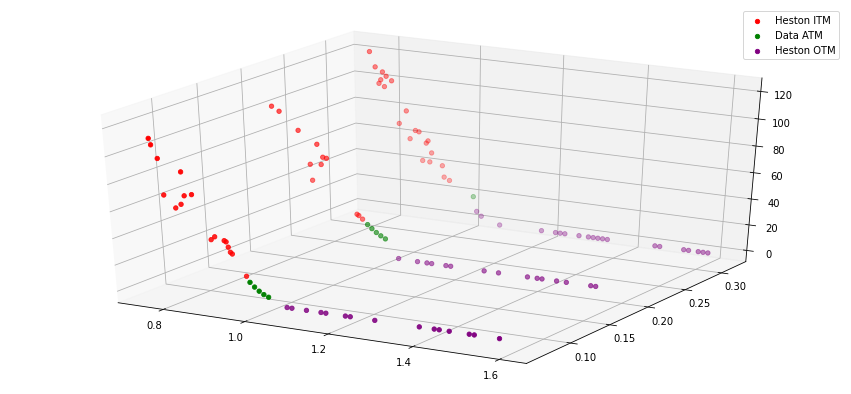

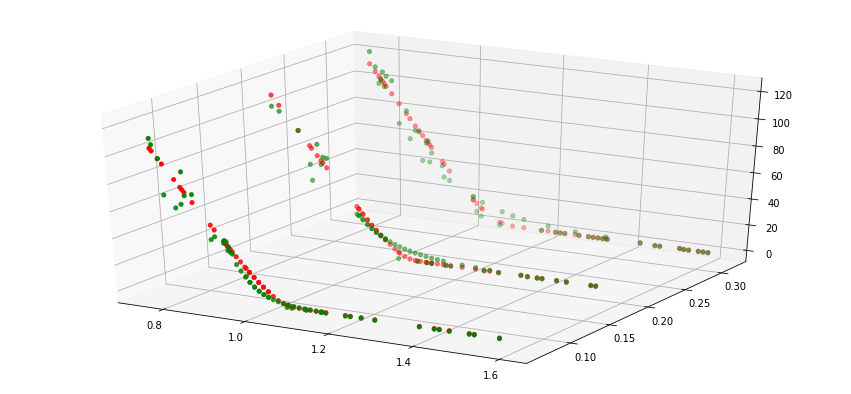

Training loss: 12795.7080078125


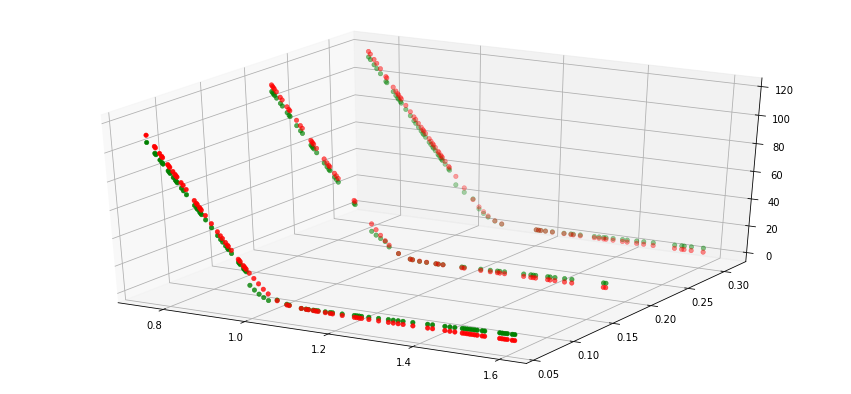

Training loss: 992.2801513671875


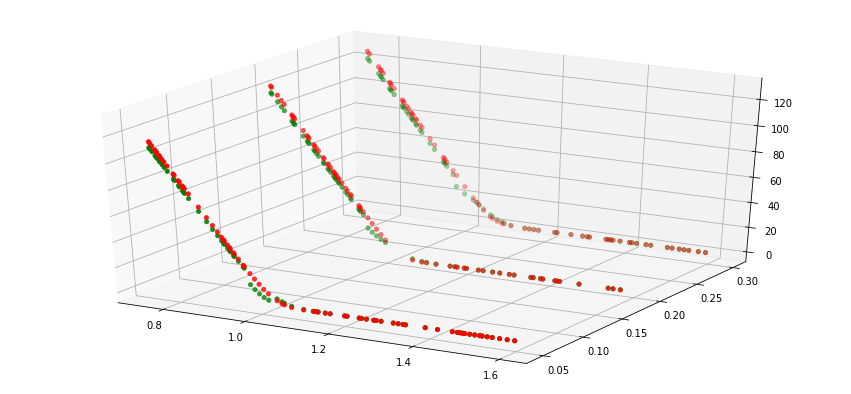

Training loss: 428.0431213378906


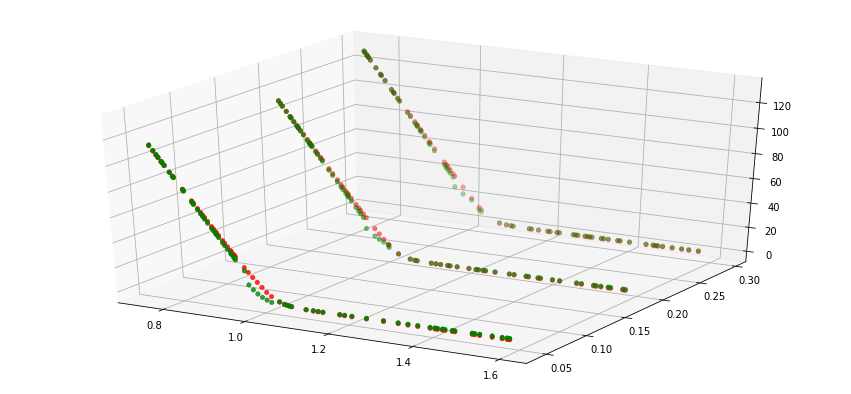

Training loss: 7881.85400390625
Training loss: 1486.48388671875
Training loss: 783.2847290039062
Training loss: 1072.80126953125
Training loss: 290.6488342285156
Training loss: 445.91754150390625


################################
PROGRESS IN THE DATA: 10
################################


Training loss: 215.5363311767578
Training loss: 597.2860107421875
Training loss: 596.1014404296875
Training loss: 270.1551818847656
Training loss: 751.8086547851562
Training loss: 392.5807800292969
Training loss: 525.4239501953125
Training loss: 252.1042938232422
Training loss: 635.7506103515625
Training loss: 3292.9736328125


################################
PROGRESS IN THE DATA: 20
################################


Training loss: 1474.505859375
Training loss: 1132.8720703125
Training loss: 409.2034912109375
Training loss: 914.5350952148438
Training loss: 907.3341064453125
Training loss: 443.7073059082031
Training loss: 4193.5625
Training loss: 1067.140380859375
Training loss: 341.9873352050781
Tr

In [ ]:
GBOP.train_generative_bnn(params, 
                          lamb = 0.9, 
                          num_epochs = 3500,
                          num_epochs_2 = 800,
                          iterations = 5)

In [ ]:
filepath = r'/content/drive/MyDrive/data aqf/estimation and prediction/gbnn_estimation.csv'
savetxt(filepath, GBOP.data['EstimationGBNN'], delimiter=',')

In [ ]:
filepath = r'/content/drive/MyDrive/data aqf/estimation and prediction/gbnn_prediction.csv'
savetxt(filepath, GBOP.data['PredictionGBNN'], delimiter=',')